In [4]:
import sys

sys.path.append("../")  # go to parent dir

%load_ext autoreload
%autoreload 2


from pathlib import Path
import numpy as np
from ddmtools.analysis import ddm
from matplotlib import pyplot as plt
from ddmtools.analysis import DDM
import pandas as pd


data_path = (Path("G:") / "My Drive" / "Dynamics in Complex Fluids" / "DDM" / "Data").resolve()
experiment_path = data_path / "2BD01_1__middle1"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
CROP_SIZE = (256, 256)


ddm = DDM.from_folder(
    experiment_path,
    framerate=1.0,
    micrometre_per_pixel=0.234,
    temperature=273.0 + 21.0,
    viscosity=0.9775e-3,
)
# patch framerate
ddm.framerate = len(ddm.stack) / 10.0

ddm.stack.crop(CROP_SIZE)
ddm.stack.preload()
ddm.stack.compress()


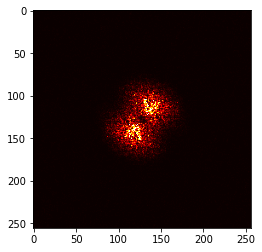

In [6]:
# Show a differential spectrum
diff = ddm.get_differential_spectrum(0, 100)
fig = ddm.plot_differential_spectrum(diff, 3)

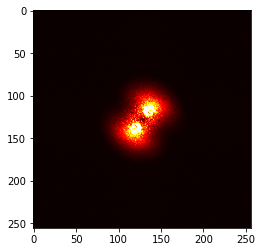

In [7]:
# Show time
average = ddm.get_time_average(400, max_couples=50)

fig = ddm.plot_time_average(average, brightness=3.0)

<Figure size 432x288 with 0 Axes>

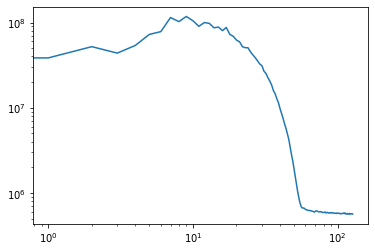

In [8]:
# Show radial average
# We can radially average since we expect isotropy

rad_average = ddm.get_radial_average(average)
fig = ddm.plot_radial_average(rad_average)
fig

In [9]:
taus = ddm.get_log_spaced_taus(150)
# taus = np.array(range(len(ddm.stack)))

times = ddm.taus_to_times(taus)
iqtaus = ddm.analyse(taus, max_couples=100)

100%|██████████| 241/241 [03:53<00:00,  1.03it/s]


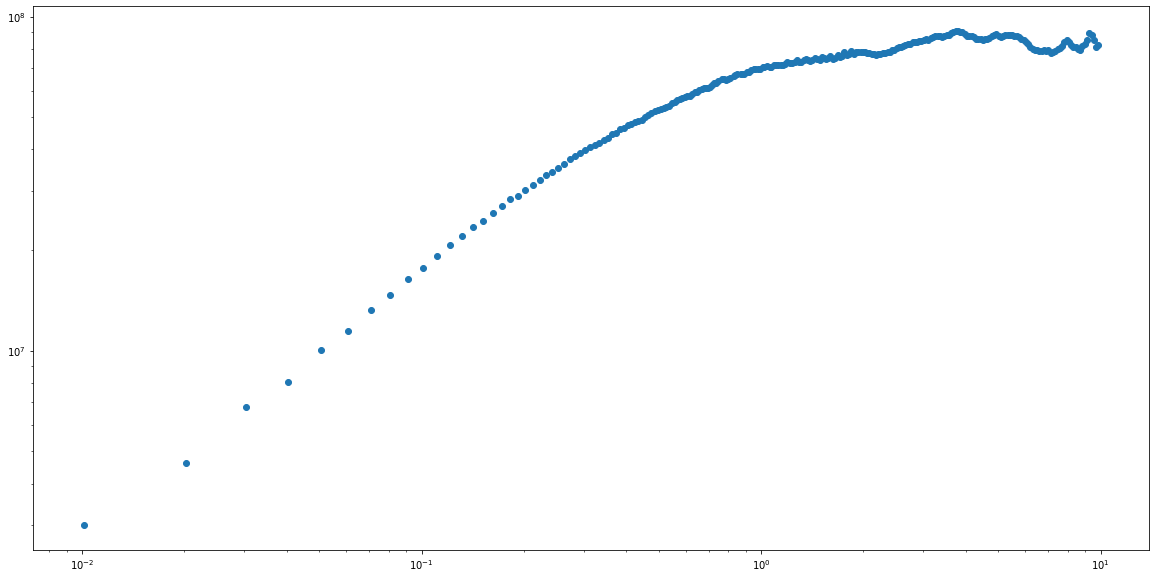

In [10]:
fig = plt.figure()
fig.set_size_inches(20, 10)
plt.xscale("log")
plt.yscale("log")
plt.plot(times, iqtaus[:, 15], "o")

In [11]:
qs = ddm.iqtaus_to_qs()
print(len(times), len(qs))

241 128


In [12]:

# %lprun -f ddm.fit_image_structure_functions_lmfit ddm.fit_image_structure_functions_lmfit(1)
dispersity_order = 2
min_result = ddm.fit_image_structure_functions_polydisperse(dispersity_order, method_sequence=["leastsq"], max_nfev=10000)
# a.params.pretty_print()

# DOF = (n-1) + q(1+1+1+(n-1))
# DOF = -1 + n + q(2+n)
# DOF = -1 + n + +2q + qn
# DOF = qn + 2q + n -1
# q = 64, n = 1 => DOF = 192
# q = 64, n = 2 => DOF = 257
# q = 64, n = 3 => DOF = 322
# q = 64, n = 4 => DOF = 387
# q = 64, n = 5 => DOF = 452
# q = 64, n = 6 => DOF = 517

# Speed: (for 10000 evals, N=2, q = 64)
# loop based method: 1:41
# Array based method: 40.4
# Array based method with njit: 1:27
# Array based method with fastmath: 1:27

print(f"Objective function evaluations: {min_result.minimizer_result.nfev}")




# assert False  # Prevent running over

Doing fit 1/1 using method `leastsq`...
Done.
Objective function evaluations: 10000


In [13]:
# min_result.minimizer_result  # Warning: very verbose

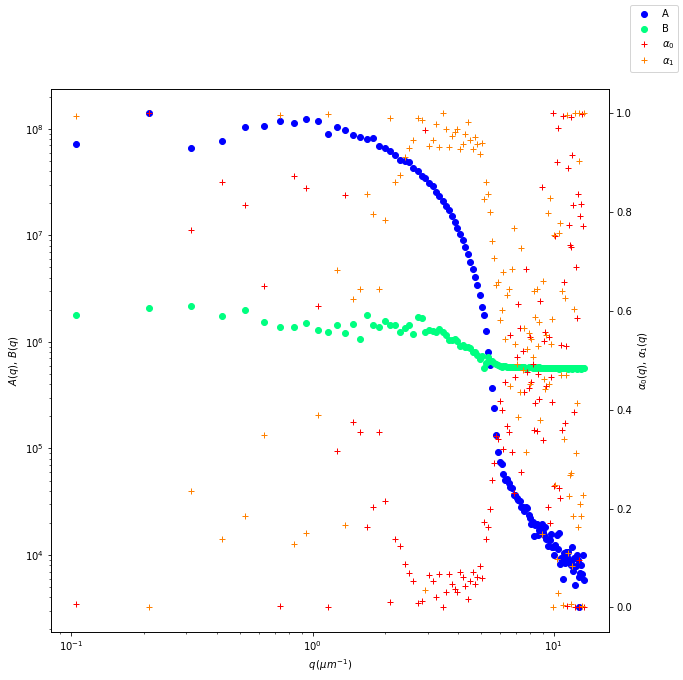

In [14]:
fig = min_result.plot_image_structure_function_params()

c:\Users\jeppe\Code\DDMTools\.venv\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jeppe\Code\DDMTools\.venv\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


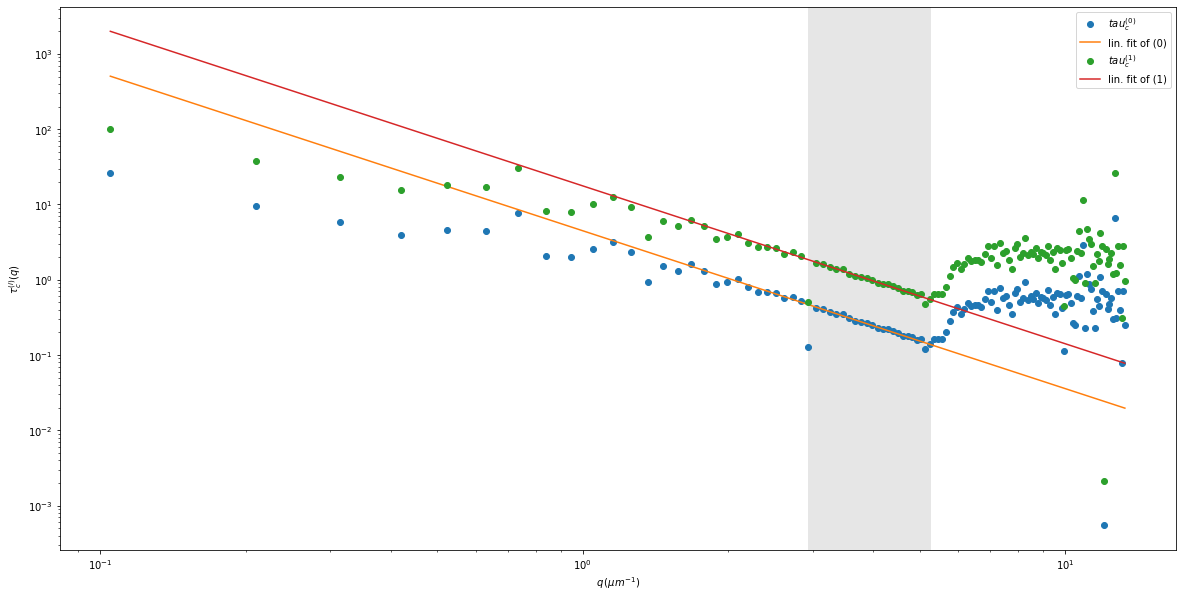

In [15]:
fit_result = min_result.fit_diffusion_coefficients(minimal_r_squared=0.97)
fig = fit_result.plot_diffusion_coeff_fit()


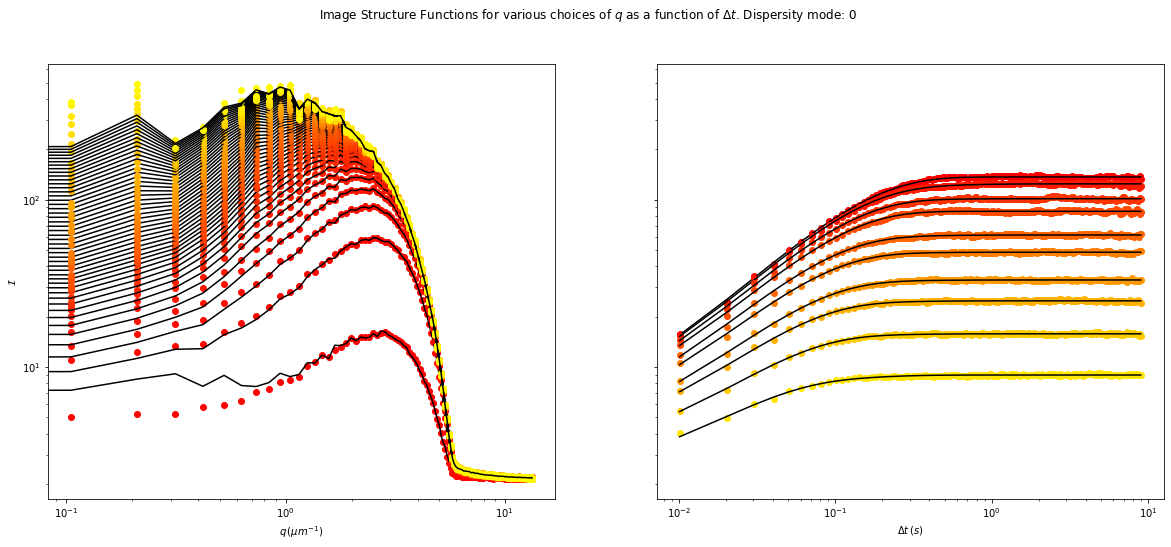

In [16]:
fig = fit_result.plot_image_structure_functions()

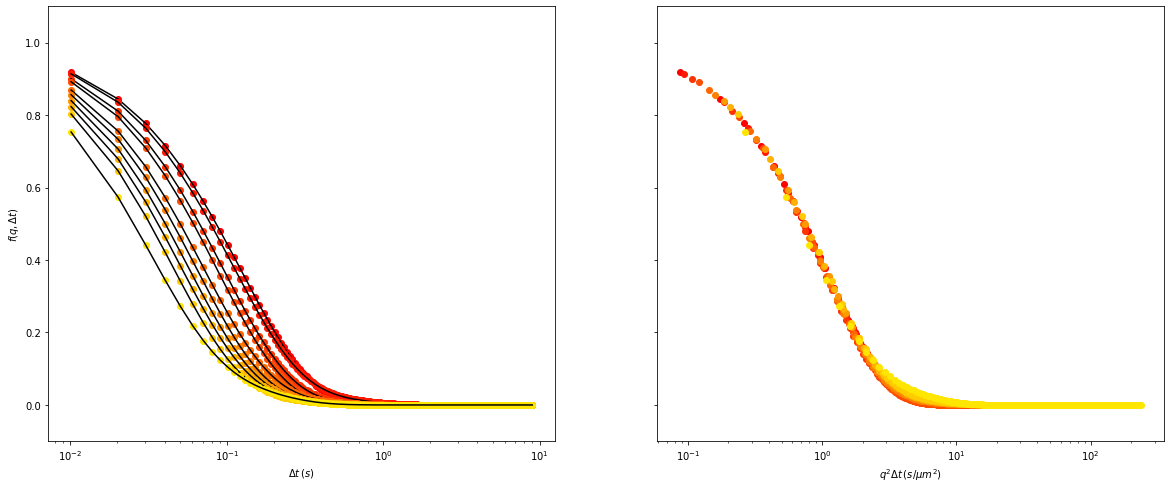

In [17]:
fig = fit_result.plot_intermediate_scattering_function(1)

In [18]:
print(fit_result.get_diffusion_coefficients())
print(fit_result.get_particle_diameters())

[0.22308835275390163, 0.05653419929555821]
[3.647017241286573e-07, 1.4391414028351221e-06]
